In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np
import copy
import time
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands

import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero
from romeo_foot import RomeoFoot

from dotmap import DotMap
import pickle

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
SCENARIO = 'building'
LOCAL = True
N_EXPS = 6
LOGS = []

for IDX in range(N_EXPS):
    file_name = 'walk_'
    data_path = parentdir + '/data/'
    file_name = file_name + SCENARIO + str(IDX)
    if LOCAL:
        file_name += '_local'
    data_path += 'ns3/exp_data/'
    exp_data = pickle.load(open( data_path + file_name + '.pkl', "rb" ) )
    if exp_data.success:
        LOGS.append(exp_data.log)
        
import itertools
LOGS_CAT = list(itertools.chain.from_iterable(LOGS))

In [4]:
N_SIMULATION = exp_data.N_SIMULATION
dt = exp_data.dt
N_STEPS = exp_data.N_STEPS
ONBOARD_WINDOW = exp_data.ONBOARD_WINDOW
STEP_DURATION = exp_data.STEP_DURATION
NS3 = exp_data.NS3

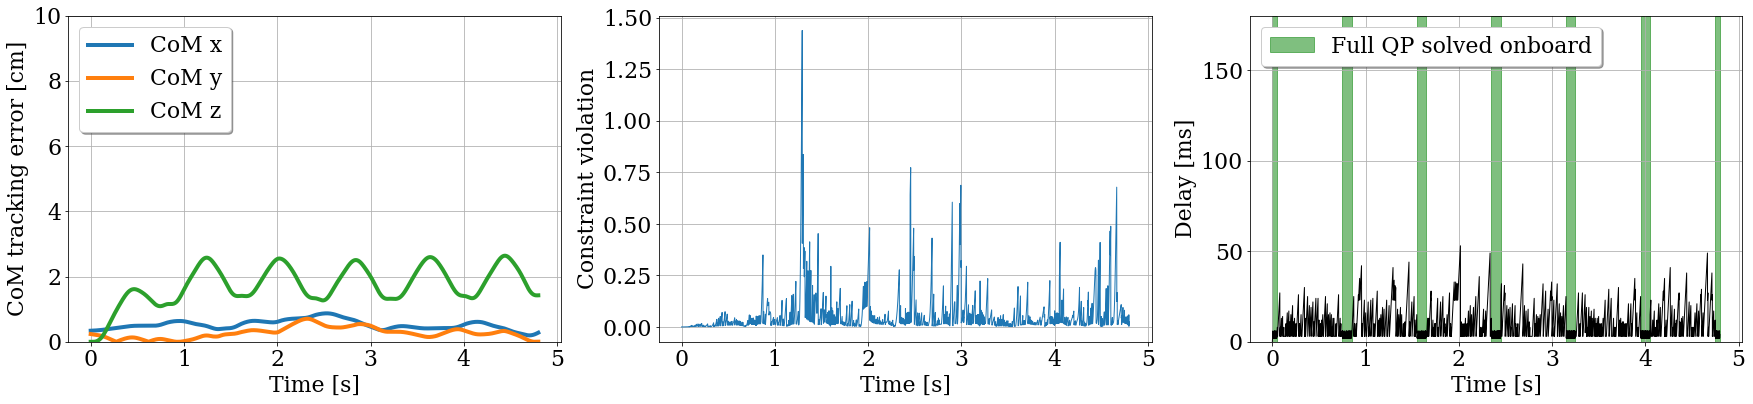

In [7]:
LOG = LOGS[5]
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
for i in range(3):
    err = 100*np.abs([data.com.pos[i,0]-data.com.pos_ref[i,0] for data in LOG])
    ax[0].plot(time, err, lw=4, label='CoM '+axes[i])
    
ax[0].grid()
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('CoM tracking error' + ' [cm]' )
_ = ax[0].legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
ax[0].set_ylim([0, 10])

slack = [data.slack[1, 0] for data in LOG]
ax[1].plot(time, slack, lw=1)
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Constraint violation' )
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax[1].set_ylim([0, 20])

delays = [data.delay for data in LOG]
ax[2].grid()
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Delay [ms]' )           
ax[2].plot(time, delays, lw=1, color='k')
ax[2].set_ylim([0, 180])


for s in range(N_STEPS + 1):
    lb = ONBOARD_WINDOW
    ub = ONBOARD_WINDOW
    if s == 0:
        lb = 0
    if s == N_STEPS:
        ub = 0
    ax[2].axvspan(1e-3*(s * STEP_DURATION - lb), 
                  1e-3*(s * STEP_DURATION + ub), 
                  alpha=0.5, color='green',
                  label="_"*s + "Full QP solved onboard")
    _ = ax[2].legend(loc='upper left', fancybox=True, shadow=True)

file_name = 'walk_err_'
if NS3:
    file_name += SCENARIO
    file_name += str(IDX)
if LOCAL:
    file_name += '_local'
    
plot_path = parentdir + '/data/plots/'
# fig.savefig(plot_path + file_name + '.png', bbox_inches='tight')

### Computation time

In [8]:
print np.mean([1000*data.fullqp_time for data in LOGS_CAT])
print np.mean([1000*data.local_time for data in LOGS_CAT])
print np.max([1000*data.fullqp_time for data in LOGS_CAT])
print np.max([1000*data.local_time for data in LOGS_CAT])

0.37621214985847473
0.10090164012379116
3.1280517578125
0.2238750457763672


### Active set change

In [9]:
M = 100
com_diff = [[] for m in range(M)]
slack = M * [[] for m in range(M)]
K = set()

for data in LOGS_CAT:
    error = DotMap()

    activeset_cached = data.activeset
    activeset_true = data.activeset_fullqp
    activeset_cached = set(np.array(activeset_cached).flatten())
    activeset_true = set(np.array(activeset_true).flatten())
    
    k = len(activeset_cached - activeset_true)
    K.add(k)
    com_diff[k].append(np.linalg.norm(data.com.pos[:,0]-data.com.pos_ref[:,0]))
    slack[k].append(data.slack[1,0])

M = max(K)
for m in range(M):
    print m, np.mean(com_diff[m]), np.mean(slack[m])

0 0.01859037785179573 0.052328938968434414
1 0.01930978610135087 0.0145751520209871
2 0.01991810779104953 0.024036402076206463
3 0.02025313728879429 0.0196227607183666
4 0.017671441741963567 0.022377914828856163
5 0.014694950337327168 0.021139018560448832
6 0.01501055670955222 0.030374958565599814
7 0.01592359594518425 0.04178139971207869
8 0.016917962694618347 0.05136065253536286
9 0.014586303649137222 0.046082338464657334
10 0.015265403336625065 0.0993145781275469
11 0.01378080082497452 0.14091652397993765
